In [1]:
import __init__

Navigated to package root: /home/cyprien/CrystaLLMv2_PKV
Added package root to Python path


### Preprocessing

#### Mattergen Density (Mother Dataset)
- Dataset: Source [Mattergen Alex-MP-20](https://github.com/microsoft/mattergen/tree/main/data-release/alex-mp)
  - Columns: Database (manual) 
  - Reduced Formula (Source)
  - CIF (pmg - Cifwriter with symprec 0.1)
  - energy_above_hull (Source), 
  - Density (g/cm^3) (pmg - structure.density)
- Deduplicated
- Cleaned for CIF augmentation, normalisations:
  - $E_{hull}$ and Density - min-max
- Note: I didnt filter to context length here because it was not implemented yet, but filter to context was flagged as True during model training which effectively does the same thing (less efficient)
- Pushed to huggingface with 90:10 train/eval as c-bone/mattergen_den_ehull

#### Mattergen Density Subsets
- Randomly sampled 1K, 10K, and 100K from the mother dataset
  - df.sample(n=target_size, random_state=1)
- Pushed to Huggingface with 90:10 train/eval as
  - c-bone/mattergen_den_ehull_1K
  - c-bone/mattergen_den_ehull_10K
  - c-bone/mattergen_den_ehull_100K


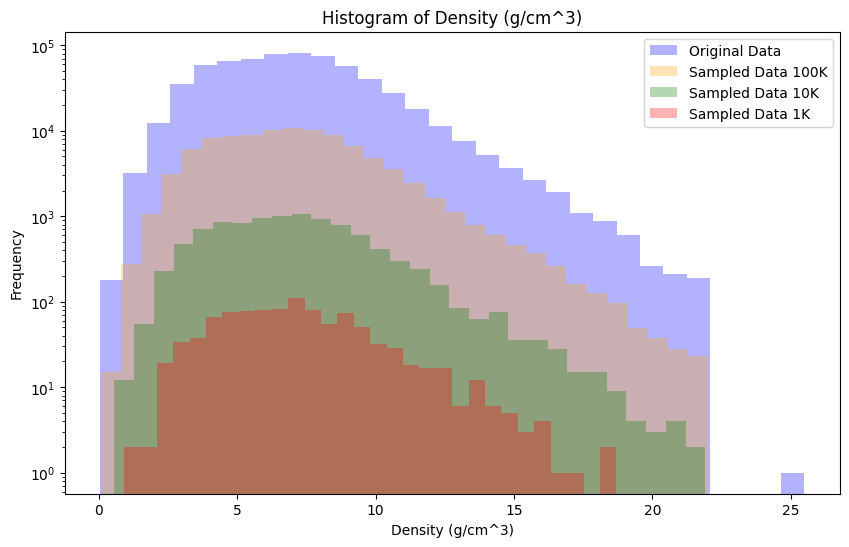

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import __init__

# Density distribution comparison across different dataset sizes
datasets = {
    'Original Data': 'HF-databases/mattergen_dev/mattergen_den_ehull_clean.parquet',
    'Sampled Data 100K': 'HF-databases/mattergen_dev/mattergen_den_ehull_clean_100K.parquet',
    'Sampled Data 10K': 'HF-databases/mattergen_dev/mattergen_den_ehull_clean_10K.parquet',
    'Sampled Data 1K': 'HF-databases/mattergen_dev/mattergen_den_ehull_clean_1K.parquet'
}
data = {name: pd.read_parquet(path) for name, path in datasets.items()}

density_col = 'Density (g/cm^3)'
colors = ['blue', 'orange', 'green', 'red']
labels = list(datasets.keys())

# Plotting histograms
plt.figure(figsize=(10, 6))
for i, (label, df) in enumerate(data.items()):
    plt.hist(df[density_col], bins=30, alpha=0.3, label=label, color=colors[i], density=False)

plt.legend()
plt.yscale('log')
plt.xlabel('Density (g/cm^3)')
plt.ylabel('Frequency')
plt.title('Histogram of Density (g/cm^3)')
plt.show()

#### Training the models

In [ ]:
sizes = ['-1k', '-10k', '-100k', '']
models = ['slider', 'prepend', 'PKV']

for size in sizes:
    for model in models:
        config_path = f'_config_files/training/conditional/dataset_size_study/mgen_ft-den{size}-{model}.jsonc'
        
        !torchrun --nproc_per_node=2 _train.py --config config_path

#### CIF generation for each

In [ ]:
for size in sizes:
    for model in models:
        # _config_files/generation/conditional/dataset_size_study/mgen_ft-den-1k-PKV_eval.jsonc
        gen_config_path = f'_config_files/generation/conditional/dataset_size_study/mgen_ft-den{size}-{model}_eval.jsonc'

        !python _utils/_generating/generate_CIFs.py --config gen_config_path

### Metrics for each

In [ ]:
for size in sizes:
    for model in models:
        # _artifacts/dataset_size_study/mgen_ft-den-1k-PKV_gen.parquet
        gen_structs_path = f'_artifacts/dataset_size_study/mgen_ft-den{size}-{model}_gen.parquet'

        postprocessed_path = f'_artifacts/dataset_size_study/mgen_ft-den{size}-{model}_post.parquet'

        !python _utils/_metrics/VUN_metrics.py \
            --input_parquet gen_structs_path \
            --huggingface_dataset 'c-bone/mattergen_den_ehull' \
            --load_processed_data 'HF-databases/mattergen_dev/mgen_den_ehull_proc.parquet' \
            --output_parquet posprocessed_path \
            --num_workers 32

        !python _utils/_metrics/property_metrics.py \
            --post_parquet posprocessed_path \
            --output_parquet posprocessed_path \
            --property_targets ["Density (g/cm^3)", "energy_above_hull"] \
            --num_workers 16 \
            --property1_normaliser "linear" \
            --property2_normaliser "linear" \
            --max_property1 25.494 \
            --min_property1 0.0 \
            --max_property2 0.1 \
            --min_property2 0.0

#### Plot results

In [3]:
import __init__
from __scripts_in_dev._plotting import make_density_comparison_plot
import pandas as pd
from datasets import load_dataset
from _utils import get_metrics_dataset_size_study

sizes = ['-1k', '-10k', '-100k', '']
models = ['slider', 'prepend', 'PKV']

dfs = {}
for size in sizes:
    for model in models:
        postprocessed_path = f'_artifacts/dataset_size_study/mgen_ft-den{size}-{model}_post.parquet'
        dfs[f'mgen_ft-den{size}-{model}'] = pd.read_parquet(postprocessed_path)

ds = load_dataset('c-bone/mattergen_den_ehull', split='train')
train_df = ds.to_pandas()

In [4]:
metrics = get_metrics_dataset_size_study(
    dfs, 
    train_df=train_df
)

Slider: Pearson r (valid count vs size) = 0.199
Prepend: Pearson r (valid count vs size) = 0.336
PKV: Pearson r (valid count vs size) = 0.294
Slider: Avg MAE = 6.351 ± 1.660
Prepend: Avg MAE = 6.193 ± 1.681
PKV: Avg MAE = 5.236 ± 1.506
Slider: Avg std = 1.956 ± 0.188
Prepend: Avg std = 1.991 ± 0.214
PKV: Avg std = 1.786 ± 0.179
Slider (1k): Avg valid count = 880.7 ± 15.6
PKV (1k): Avg valid count = 818.0 ± 13.1
Prepend (1k): Avg valid count = 729.7 ± 12.1
t-test Slider vs PKV MAE: t=4.123, p=0.002
t-test Prepend vs PKV MAE: t=3.515, p=0.005
